In [2]:
%matplotlib notebook

import sys
import os
import time

In [3]:
# sys.path.append('d:/code/broadbean/')
# sys.path.append('d:/code/labtools')

In [4]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt
from broadbean.plotting import plotter
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import plots as mplplots
from labtools.mplplots import tools as mpltools

# Initialization

## Classes and methods

## Load Instruments

In [5]:
from pytopo.qctools import instruments as instools
from pytopo.rf.alazar_acquisition import RawAcqCtl, DemodAcqCtl, DemodRelAcqCtl, IQAcqCtl

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
inst_list.append(demod_acq)

rel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
inst_list.append(rel_acq)

iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
inst_list.append(iq_acq)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg5014 = instools.create_inst(Tektronix_AWG5014, 'awg5014', address="TCPIP0::169.254.183.196::inst0::INSTR")
inst_list.append(awg5014)

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.234.107")
inst_list.append(LO)
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20")
inst_list.append(RF)

station = qc.Station(*inst_list)

Instrument alazar already exists.
Instrument raw_acq already exists.
Instrument demod_acq already exists.
Instrument rel_acq already exists.
Instrument iq_acq already exists.
Instrument awg5014 already exists.
Instrument RF already exists.
Instrument LO already exists.


Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

# Specify a sequence

## Use broadbean to specify a mock qubit spec sequence

In [7]:
ramp = bb.PulseAtoms.ramp
delay = bb.PulseAtoms.waituntil

<IPython.core.display.Javascript object>


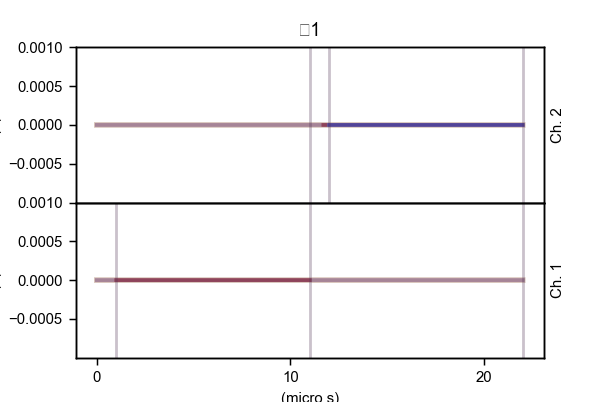

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


In [10]:
SR = 1e9
initial_delay = 1e-6
qb_pulse_len = 1e-5
ro_delay = 1e-6
ro_pulse_len = 1e-5
alz_trigger_len = 100e-9
alz_trigger_buf = 200e-9

spec_elem = bb.Element()

qubit = bb.BluePrint()
qubit.setSR(SR)
qubit.insertSegment(0, ramp, (0, 0), dur=initial_delay)
qubit.insertSegment(-1, ramp, (0, 0), dur=qb_pulse_len, name='qb_pulse')
qubit.insertSegment(-1, ramp, (0, 0), dur=ro_delay + ro_pulse_len)
qubit.setSegmentMarker('qb_pulse', (0, qb_pulse_len), 1)

readout = bb.BluePrint()
readout.setSR(SR)
readout.insertSegment(0, ramp, (0, 0), dur=initial_delay + qb_pulse_len)
readout.insertSegment(-1, ramp, (0, 0), dur=ro_delay, name='ro_delay')
readout.insertSegment(-1, ramp, (0, 0), dur=ro_pulse_len, name='ro_pulse')
readout.setSegmentMarker('ro_delay', (ro_delay - alz_trigger_len - alz_trigger_buf, alz_trigger_len), 1)
readout.setSegmentMarker('ro_pulse', (0, ro_pulse_len), 2)

spec_elem.addBluePrint(2, readout)
spec_elem.addBluePrint(1, qubit)

seq = bb.Sequence()
seq.name = 'qubit_spec'

seq.addElement(1, spec_elem)
seq.setSR(SR)

seq.setChannelAmplitude(1, 1)
seq.setChannelOffset(1, 0)
seq.setChannelAmplitude(2, 1)
seq.setChannelOffset(2, 0)

seq.setSequencingTriggerWait(1, 0)
seq.setSequencingGoto(1, 1)

plotter(seq)

## Program the AWG and play

In [11]:
awg5014.stop()
awg5014.clock_freq(SR)
pkg = seq.outputForAWGFile()
awg5014.make_send_and_load_awg_file(*pkg[:])

In [12]:
awg5014.ch1_state(1)
awg5014.ch2_state(1)
awg5014.start()

'Running'

# Alazar Acquisition Examples

## Configure Alazar

In [13]:
ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(1e9),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)

## Run Tests

Triggers on the signal. make sure you're playing someting :)

<IPython.core.display.Javascript object>


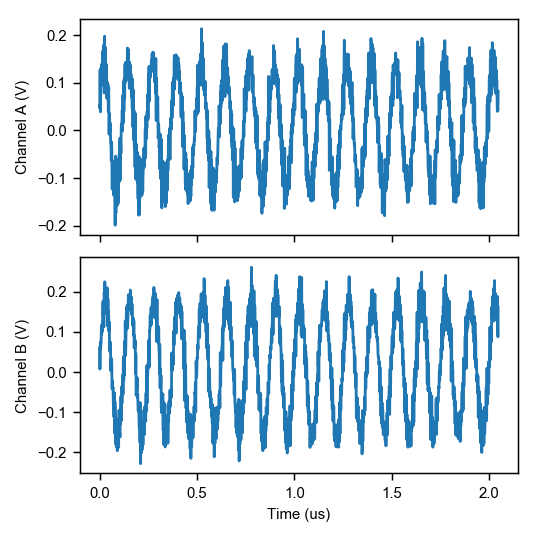

In [14]:
raw_acq.acq_time = 2e-6
raw_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=1,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = raw_acq.do_acquisition()

fig, (ax, bx) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax.plot(raw_acq.tvals * 1e6, np.squeeze(data)[:, 0])
bx.plot(raw_acq.tvals * 1e6, np.squeeze(data)[:, 1])

ax.set_ylabel('Channel A (V)')
bx.set_ylabel('Channel B (V)')
bx.set_xlabel('Time (us)')

fig.tight_layout()

In [11]:
raw_acq.handling_times

array([ 0.31182125])

<IPython.core.display.Javascript object>


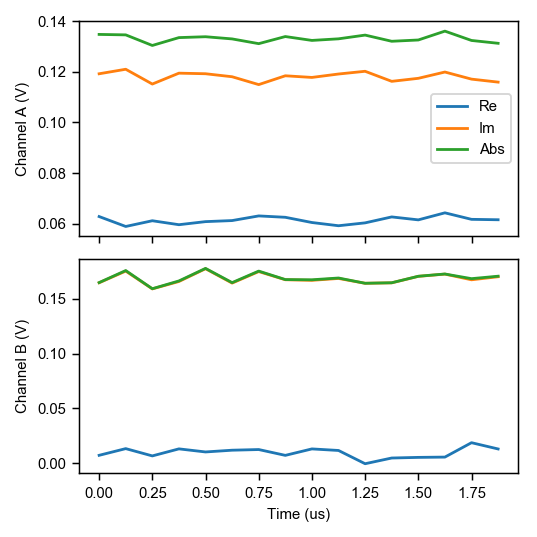

In [16]:
demod_acq.acq_time = 2e-6
demod_acq.demod_frq = 8e6
demod_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                   buffers_per_acquisition=1,
                                   buffer_timeout=10000,
                                   allocated_buffers=1)
data = demod_acq.do_acquisition()

fig, (ax, bx) = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 0].real, label='Re')
ax.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 0].imag, label='Im')
ax.plot(demod_acq.demod_tvals * 1e6, np.abs(np.squeeze(data)[:, 0]), label='Abs')
ax.legend()

bx.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 1].real)
bx.plot(demod_acq.demod_tvals * 1e6, np.squeeze(data)[:, 1].imag)
bx.plot(demod_acq.demod_tvals * 1e6, np.abs(np.squeeze(data)[:, 1]))

ax.set_ylabel('Channel A (V)')
bx.set_ylabel('Channel B (V)')
bx.set_xlabel('Time (us)')

fig.tight_layout()

In [15]:
demod_acq.handling_times

array([ 0.89636391])

<IPython.core.display.Javascript object>


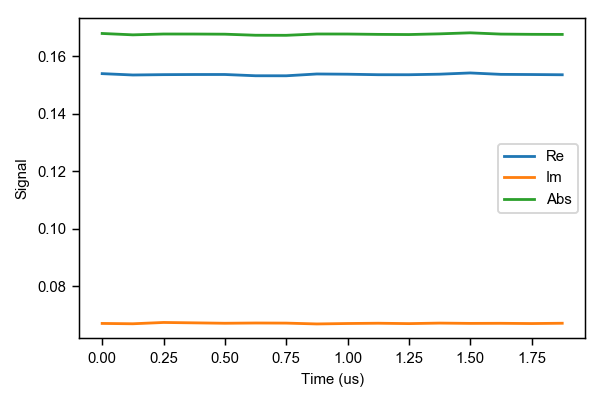

In [18]:
rel_acq.acq_time = 2e-6
rel_acq.demod_frq = 8e6
rel_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                 buffers_per_acquisition=1000,
                                 buffer_timeout=10000,
                                 allocated_buffers=1)
data = rel_acq.do_acquisition()

fig, ax = plt.subplots(1, 1)
ax.plot(rel_acq.demod_tvals * 1e6, np.squeeze(data).mean(axis=0).real, label='Re')
ax.plot(rel_acq.demod_tvals * 1e6, np.squeeze(data).mean(axis=0).imag, label='Im')
ax.plot(rel_acq.demod_tvals * 1e6, np.abs(np.squeeze(data).mean(axis=0)), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()

In [ ]:
rel_acq.handling_times

(10, 1) [ 4.42365853  0.25219399  0.2238466   0.19452172  0.19256673  0.1759493
  0.19012299  0.17252806  0.17155056  0.20722917]


<IPython.core.display.Javascript object>


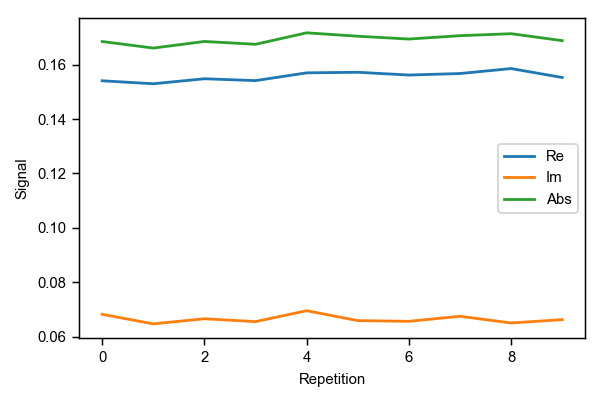

In [19]:
iq_acq.acq_time = 2e-6
iq_acq.demod_frq = 8e6
iq_acq.update_acquisitionkwargs(records_per_buffer=1, 
                                buffers_per_acquisition=10,
                                buffer_timeout=10000,
                                allocated_buffers=1)
data = iq_acq.do_acquisition()
print(data.shape, iq_acq.handling_times)

fig, ax = plt.subplots(1, 1)
ax.plot(np.squeeze(data).real, label='Re')
ax.plot(np.squeeze(data).imag, label='Im')
ax.plot(np.abs(np.squeeze(data)), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Repetition')

fig.tight_layout()

In [ ]:
station.snapshot()